<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Time Series Independent Practice

## Walmart Sales Data

For this practice, we'll analyse Walmart's weekly sales data over a two-year period from 2010 to 2012.

The dataset is separated by store and department.

The data includes:

* `Store`: The store number.
* `Dept`: The department number.
* `Date`: The week.
* `Weekly_Sales`: Sales for the given department in the given store.
* `IsHoliday`: Whether the week is a special holiday week.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

walmart = pd.read_csv('../assets/data/walmart_sales.csv.gz')

### 1) Convert the `Date` column to a `datetime` object.

In [2]:
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [3]:
walmart.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [4]:
walmart['Date'] = pd.to_datetime(walmart['Date'])

In [5]:
walmart.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

In [6]:
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


### 2) Do some EDA, answering questions like:

- which stores sell more/less than others?
    - remember that we have departments within stores, so think about how this would make sense to do!
- what do sales like for different months?

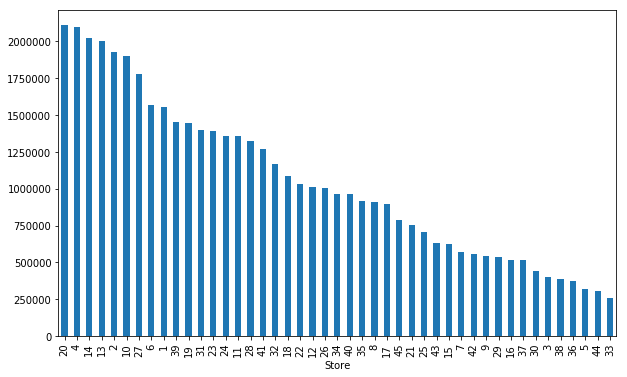

In [7]:
# add daily sales by store (i.e. aggregating over departments)
weekly_sales_by_store = walmart.groupby(["Store", "Date"])["Weekly_Sales"].sum().reset_index()

# get the month
weekly_sales_by_store["month"] = weekly_sales_by_store["Date"].dt.month

# plot average daily sales by store
fig, ax = plt.subplots(figsize=(10, 6))
weekly_sales_by_store.groupby("Store")["Weekly_Sales"].mean().sort_values(ascending=False).plot.bar(ax=ax)
plt.show()

Quite a high variability in stores - explained by number of departments?

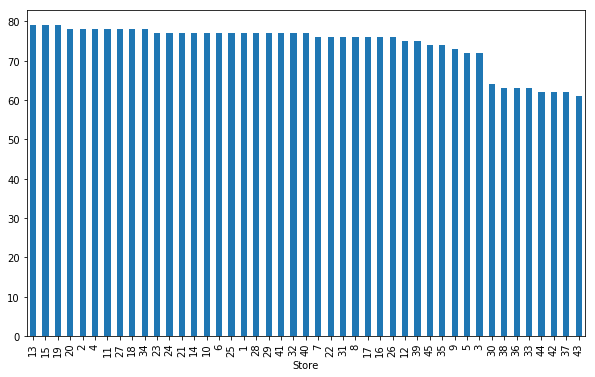

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
walmart.groupby("Store")["Dept"].nunique().sort_values(ascending=False).plot.bar(ax=ax)
plt.show()

There are indeed some stores with different numbers of departments. If we were interested in this in more detail, we could look at the relationship between store size and sales and find outliers etc.

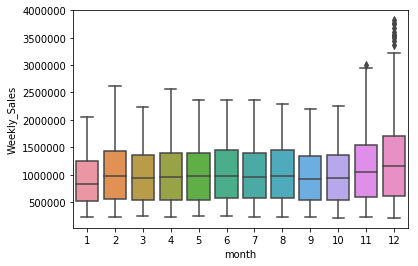

In [9]:
sns.boxplot(x="month", y="Weekly_Sales", data=weekly_sales_by_store);

Unsurprisingly we have more sales over Christmas and fewer in January!

### 3) Extract just Store 1's weekly sales into a new Series

If you haven't already, make sure you aggregate over department so that we have exactly one row per week.

In [10]:
store1 = walmart[walmart["Store"] == 1]
store1.set_index("Date", inplace=True)
store1 = store1["Weekly_Sales"].resample("W").sum()
store1.head()

Date
2010-02-07    1643690.90
2010-02-14    1641957.44
2010-02-21    1611968.17
2010-02-28    1409727.59
2010-03-07    1554806.68
Freq: W-SUN, Name: Weekly_Sales, dtype: float64

### 4) Plot Store 1's weekly sales. What do you observe?

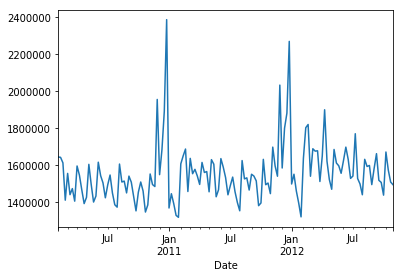

In [11]:
store1.plot();

Perhaps a slight rising trend, and large Christmas spikes

### 5) Plot the autocorrelation and partial autocorrelation. What do you conclude?

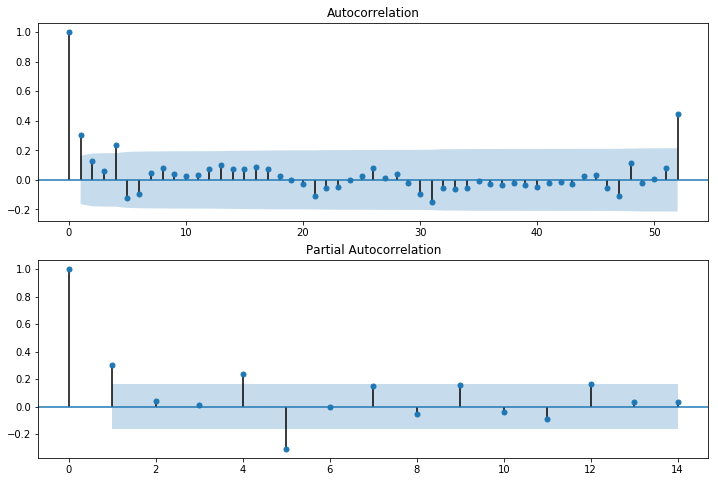

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(store1, lags=52, ax=ax[0])
plot_pacf(store1, lags=14, ax=ax[1])

plt.show()

The previous week seems weakly correlated, but mostly uncorrelated.

In fact the strongest correlation is the same week the year before!

### 6) Create a decomposition plot for the Store 1 sales data. What do you see?

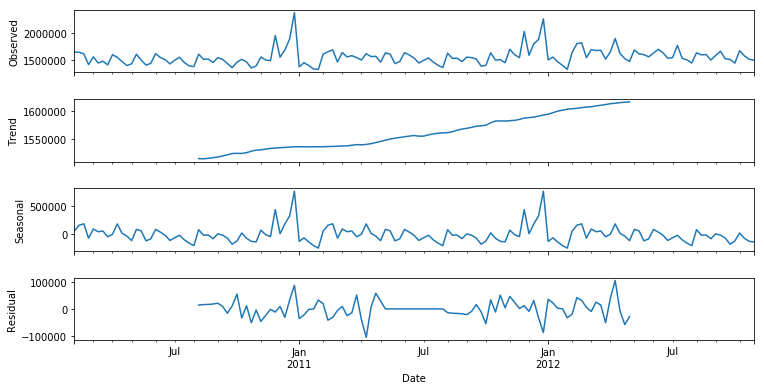

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(store1, freq=52)
fig = decomposition.plot()
fig.set_size_inches(12, 6)

plt.show()

Definite seasonality around Christmas, and a small upward trend (note the misleading axis for the Trend plot!)

### 7) Create an appropriate train-test split in preparation for forecasting

In [14]:
print(store1.index.min(), store1.index.max())

2010-02-07 00:00:00 2012-10-28 00:00:00


In [15]:
# let's use "up to November 2011" as the training set and the rest as test, so we incorporate one Christmas forecast
train = store1[:"2011-10-30"]
test = store1["2011-11-06":]
print(len(train), len(test))

91 52


### 8) Fit an ARIMA model and plot the forecast on top of the real values

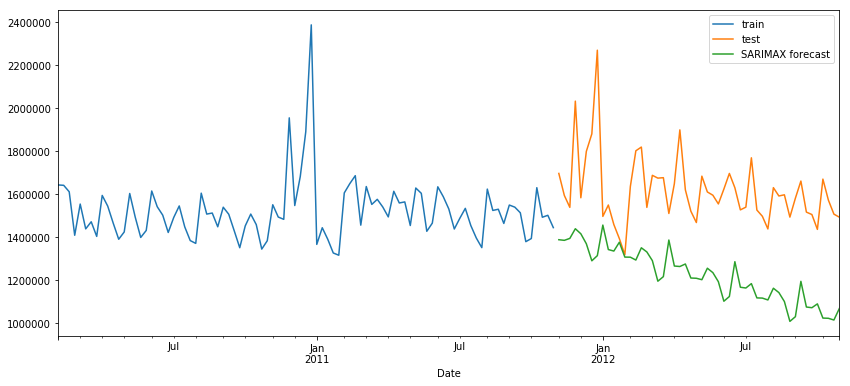

In [16]:
import statsmodels.api as sm

model = sm.tsa.SARIMAX(train, order=(1, 1, 0), seasonal_order=(1, 1, 0, 12)).fit()
y_pred = model.predict(start="2011-11-06", end="2012-10-28")

fig, ax = plt.subplots(figsize=(14, 6))

train.plot(ax=ax, label="train")
test.plot(ax=ax, label="test")
y_pred.plot(ax=ax, label="SARIMAX forecast")
ax.legend()

plt.show()

### 9) As we have predictions and real values, we can see how we're doing. Calculate the RMSE of your model. How is it doing?

In [17]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(test, y_pred))

428630.79625354614

### 10) BONUS: experiment with different parameter values to see the effects!

Can you improve your RMSE?

376307.389639


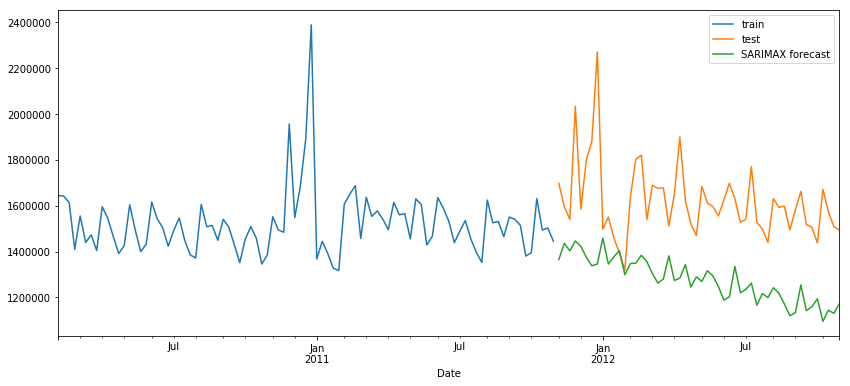

In [18]:
import statsmodels.api as sm

model = sm.tsa.SARIMAX(train, order=(2, 1, 0), seasonal_order=(2, 1, 0, 12)).fit()
y_pred = model.predict(start="2011-11-06", end="2012-10-28")

fig, ax = plt.subplots(figsize=(14, 6))

train.plot(ax=ax, label="train")
test.plot(ax=ax, label="test")

y_pred.plot(ax=ax, label="SARIMAX forecast")

print(np.sqrt(mean_squared_error(test, y_pred)))

ax.legend()

plt.show()

Adding another AR terms seems to have helped. We're still £376k off but absolute values are over £1 million so it's not terrible, and extrapolating over a year will always be difficult!